# EP2 - MAC0425 (Inteligência Artificial) : Previsão de Estágio da Infecção por COVID-19 - Dados do HC

João Pedro Barioni Agostini (14582163)  
Nathália Yukimi Uchiyama Tsuno (14600541)

# 1. Preparações para o código

## 1.1. Importando as bibliotecas

In [1]:
#===================================================#
# Bibliotecas utilizadas no gerenciamento dos dados #
#===================================================#

import pandas as pd
from collections import defaultdict
import re
import numpy as np
import unicodedata

#=============================================#
# Bibliotecas Utilizadas na Plotagem de Dados #
#=============================================#
import seaborn as sns
import matplotlib.pyplot as plt

#=======================================#
# Bibliotecas utilizadas na rede neural #
#=======================================#

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## 1.2. Preparação do arquivo do banco de dados

In [2]:
# Descompacta o arquivo zip se existir
!unzip -o -d . HC_Janeiro2021.zip

Archive:  HC_Janeiro2021.zip
  inflating: ./HC_EXAMES_1.csv       
  inflating: ./HC_PACIENTES_1.csv    
  inflating: ./HC_Dicionario_1.xlsx  


## 1.3. Carregamento do banco de dados

In [3]:
# Carregamento dos 2 bancos em dataframes do Pandas
df_exames = pd.read_csv("HC_EXAMES_1.csv", sep="|")
df_pacientes = pd.read_csv("HC_PACIENTES_1.csv", sep="|")

# Merge das colunas de exames e analitos para diferenciação
df_exames['EXAME'] = df_exames['DE_EXAME'] + ' / ' + df_exames['DE_ANALITO']

# 2. Análises iniciais sobre o estado de cada dataset


## 2.1. Dataset de Exames

O dataset de exames possui 2498650 registros, contendo diferentes exames para diferentes pacientes.

In [4]:
df_exames.head()

,ID_PACIENTE,ID_aTENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,EXAME
0,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,CULTURA AERÓBIA,CULTURA AERÓBIA,Negativa,NaN,Negativa,CULTURA AERÓBIA / CULTURA AERÓBIA
1,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URÉIA,URÉIA,10,mg/dL,10 a 50 mg/dL,URÉIA / URÉIA
2,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,pH :,7.0,NaN,5.0 a 6.0,URINA TIPO 1 / pH :
3,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Urobilinogenio :,0.2,mg/dL,0.2 a 1.0 mg/dL,URINA TIPO 1 / Urobilinogenio :
4,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Sangue :,Tracos,NaN,Ausente,URINA TIPO 1 / Sangue :


In [5]:
print(f'O dataset de exames possui {df_exames.shape[0]} registros e {df_exames.shape[1]} atributos.')

O dataset de exames possui 2498650 registros e 10 atributos.


In [6]:
display(df_exames['EXAME'].value_counts())

,count
EXAME,
POTÁSSIO / POTÁSSIO,81410
SÓDIO / SÓDIO,79461
CÁLCIO IÔNICO / CÁLCIO IÔNICO,65769
GASOMETRIA / pO2,57678
GASOMETRIA / SO2,57676
...,...
MLL-AF4 TRANSLOCAÇÃO 4:11 / T411,1
MLL-AF4 TRANSLOCAÇÃO 4:11 / PCR 1,1
MLL-AF4 TRANSLOCAÇÃO 4:11 / PCRABL,1


## 2.2. Dataset de Pacientes

O dataset de pacientes possui 3751 registros que correspondem aos pacientes.

In [7]:
df_pacientes.head()

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_PAIS,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO
0,9698838a8fa8a01ffd5ed5c71e8e17a3,F,1962,BR,SP,SAO PAULO,CCCC
1,d9fec23b3820f93a961841d569db8cb5,F,1974,BR,SP,MMMM,CCCC
2,ee507ba3a9959fdf31bca52852fd5715,F,1962,BR,SP,MMMM,CCCC
3,51590e8c53f4e8e332c05d7e6cee35c7,F,1960,BR,SP,SAO PAULO,CCCC
4,13699f0f7714fdaba277c5e360c6869c,M,1967,BR,SP,MMMM,CCCC


In [8]:
print(f'O dataset de exames possui {df_pacientes.shape[0]} registros e {df_pacientes.shape[1]} atributos.')

O dataset de exames possui 3751 registros e 7 atributos.


# 3. Processamento de Tabelas

## 3.1. União das colunas e tabelas

In [9]:
# Realiza o pivot da tabela (transforma pares de linha (exame, analito) em colunas)
df_pivot = df_exames.pivot_table(index='ID_aTENDIMENTO',
                                columns='EXAME',
                                values=['DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA'],
                                aggfunc='first')

# Formata as colunas para melhor compreensão da tabela (título =  <exame> \ <analito>)
df_pivot.columns = [f"{exame} \ {analito.lower()}" for analito, exame in df_pivot.columns]

# Une as tabelas df_exames e df_pacientes em uma só
df_exames_com_paciente = df_exames[['ID_aTENDIMENTO', 'ID_PACIENTE']].drop_duplicates()
df_pivot = df_pivot.merge(df_exames_com_paciente, on='ID_aTENDIMENTO', how='left')
df_pivot = df_pivot.merge(df_pacientes[['ID_PACIENTE', 'IC_SEXO', 'AA_NASCIMENTO']],
                          on='ID_PACIENTE',
                          how='left')

# Reseta os índices da nova tabela
df_pivot = df_pivot.reset_index()

In [10]:
display(df_pivot)

,index,ID_aTENDIMENTO,25-HIDROXIVITAMINA D / 25-HIDROXIVITAMINA D \ cd_unidade,ADENOSINA DEAMINASE / ADENOSINA DEAMINASE \ cd_unidade,AGREGAÇÃO PLAQUETÁRIA ADRENALINA / % aos 10 minutos: \ cd_unidade,AGREGAÇÃO PLAQUETÁRIA COLÁGENO / % aos 10 minutos: \ cd_unidade,"AGREGAÇÃO PLAQUETÁRIA COM ADP / ADP 1,2 MICROMOL % aos 10 minutos: \ cd_unidade","AGREGAÇÃO PLAQUETÁRIA COM ADP / ADP 2,5 MICROMOL % aos 10 minutos: \ cd_unidade",AGREGAÇÃO PLAQUETÁRIA COM ÁCIDO ARAQUIDÔNICO / % aos 10 minutos: \ cd_unidade,ALANINA AMINOTRANSFERASE / ALANINA AMINOTRANSFERASE \ cd_unidade,...,VLDL - COLESTEROL / VLDL - COLESTEROL \ de_valor_referencia,VORICONAZOL / VORICONAZOL \ de_valor_referencia,VÍRUS SINCICIAL RESPIRATÓRIO / VÍRUS SINCICIAL RESPIRATÓRIO \ de_valor_referencia,Vírus sincicial respiratório A (HRSVA) e B (HRSVB) / Vírus sincicial respiratório A (HRSVA) e B (HRSV \ de_valor_referencia,ÁCIDO FÓLICO / ÁCIDO FÓLICO \ de_valor_referencia,ÁCIDO VALPRÓICO / ÁCIDO VALPRÓICO \ de_valor_referencia,ÁCIDO ÚRICO / ÁCIDO ÚRICO \ de_valor_referencia,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO
0,0,005dc13e19b2523e0db4bf15156d6412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f88a18f43c87d534877bda69ff89b068,M,1969
1,1,00759fffd8c3fcd6a790e67a8bbfcb59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59ce0f1d16cdc3f1889442a96979ad3c,M,1951
2,2,00a495aa8cdc20aa8272e2ecab6a1c28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b9708efa3f3a88cb481970173ed33877,F,1941
3,3,00b4a366c7da2ce894a4fa7a2b1c45bb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,Deficiente inferior a 2.2 ng/mL;Deficiente lim...,NaN,NaN,ce5d1c92d88870d43288548755015d26,M,1956
4,4,00b8650bb74e3c650560486ad30a5898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ece33041542846f6aff1017fea989836,M,1942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,3172,ff71304ac140d9bfa8a60c8ae8542520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c747baa52eea0bc82413dd5ef5bc8e1d,M,1976
3173,3173,ff97502613f7d78596bb11f03a5d804d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b5a6e16f4867bd3e6ff74bada8eeefaa,F,1977
3174,3174,ffcac17b109827d315f7e873266f677d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,NaN,NaN,NaN,Não detectado,NaN,NaN,NaN,234265fced3ab85924ec8a3dbb546389,M,1948
3175,3175,fffdf1bf42e05bd179b08b3c7ad7fd74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U/L,...,;Acima de 20 anos: ;Com jejum de 12 horas: ...,NaN,NaN,NaN,NaN,NaN,Homens : 3.4 a 7.0 mg/dL,f0ac87e81d7d7ff475df830da0dfd0d3,M,1976


### 3.1.1 Descrição de Alguns Dados

## 3.2. Limpeza de colunas irrelevantes

### 3.2.1. Função auxiliar: parseamento numérico


In [11]:
def parseamento_numerico(df):
    for c in df.columns:
        try:
            # Transforma em NaN se não for numérico
            converted = pd.to_numeric(df[c], errors='coerce')
        except Exception:
            pass
    return df

### 3.2.2. Remoção dos exames com menos de 10% de adesão (exceto os importantes de Covid)

Redução de dimensionalidade é um atributo importante na Feature Engeneering. Nesse caso, buscamos eliminar colunas que não agregam de forma considerável para a classificação do paciente.

Além disso, eliminar atributos com menos de 10% de adesão favorece a mitigação da influência de outliers sobre o nosso modelo, permitindo-se uma generalização com desempenho melhor.

In [12]:
def remove_acentos(texto):
  texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
  texto = texto.encode('ascii', 'ignore').decode('utf-8')
  return texto

In [13]:
# Calcula a razão de NaNs para cada coluna
razao_nan = df_pivot.isnull().mean()

# Salva as colunas que queremos manter
manter_colunas = [col for col in df_pivot.columns if ('COVID' in col or 'CoV' in col or 'coronavirus' in remove_acentos(col.lower())) or (razao_nan[col] <= 0.1)]

print("Quantidade de colunas antes das remoções:", df_pivot.shape[1])

# Mantém apenas as colunas salvas em manter_colunas
df_pivot = df_pivot[manter_colunas]

print("Quantidade de colunas depois das remoções:", df_pivot.shape[1])

Quantidade de colunas antes das remoções: 2529
Quantidade de colunas depois das remoções: 96


### 3.2.3. Convertendo Valores Categóricos em Numéricos

Um problema do pré-processamento de dados é a falta de padronização de dados. Nesse caso, podemos perceber que muitas colunas numéricas possuíam casos isolados de dados problemáticos e mistos (como "> 0.9" numa coluna de numérica).

Isso atrapalhava o processamento final. Portanto, encontrados alguns padrões recorrentes nesses outliers, como ">", "<" e "?", foram identifcados usando RegEx. Para os valores nulos/NaN, substituímos por 0, conforme especificação do EP.

In [14]:
#====================#
# Funções Auxiliares #
#====================#

def avaliar_colunas_mistas(df_original):
  df = df_original.copy()

  # Transformando dados do tipo "Objeto" em inteiros ou float
  for c in df.columns:
    if df[c].dtype == "object" and "de_resultado" in c:
      df[c] = df[c].str.strip()
      df["tmp"] = df[c].str.extract(r'^[><=\?\+\-]*\s?(\d+\.?\d*)') # Extrai o valor numérico
      df[c] = df["tmp"].fillna(df[c])

  if "tmp" in df.columns:
    df.drop(columns=["tmp"], inplace=True)

  return df

def avaliar_NaN(df_original):
  # Conforme enunciado, para todo exame não-binário não realizado, marcar um 0

  df = df_original.copy()
  df = avaliar_colunas_mistas(df)

  n = 0 # Para todo exame não realizado, troque por 0

  for c in df.columns:
    if df[c].dtype == "object" and "de_resultado" in c:
      df[c] = df[c].str.strip()
      df[c] = df[c].str.replace(
        r"^[\*\-\?]*",
        r"",
        regex=True
      )
    df[c] = df[c].replace("", n)

  return df

# CONVERSÃO
# Transforma em RegEx os padrões encontrados
df_numerico = avaliar_NaN(df_pivot)

# Tenta transformar em numérico o que é puramente numérico
for c in df_numerico.columns:
  if df_numerico[c].dtype == "object" and "de_resultado" in c:
    try:
      df_numerico[c] = pd.to_numeric(df_numerico[c], errors='raise')
    except Exception:
      df_numerico[c] = df_numerico[c].str.strip()

/tmp/ipython-input-14-598535108.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace("", n)


### 3.2.4. Regularizando as colunas de valores binários [0, 0.5, 1]

Outra etapa importante do pré-processamento de dados para uma rede neural é a codificação de dados, transformando dados categóricos em numéricos.

Nesse caso, estamos usando um mapeamento como um label encoding binário, onde 1 corresponde à ocorrência do evento analisado e 0, caso contrário. Além disso, como especificação do enunciado, para valores ternários e que não sejam equivalentes a NaN, como "Inconclusivo", transformamos para 0.5.

Ademais, para todos os dados inválidos, como "Ausente" e "neg", transformamos em 0.

Para os valores de NaN, ainda serão necessaŕios, pois precisamos distinguir pacientes que fizeram o exame da COVID-19, mas, não sabem o resultados, daqueles que nem o fizeram (e que, portanto, não são relevantes para o nosso modelo).

In [15]:
# Função auxiliar: regulariza os valores em binário

def mapeamento_binario(valor):
  valor_string = str(valor).strip().lower()
  if valor_string in ['true', 'positivo', 'detectado', 'reativo', 'presente', 'normal', 'sim', 'positivo/reagente', 'reagente']:
    return 1
  elif valor_string in ['false', 'negativo', 'não detectado', 'não reativo', 'ausente', 'nao reagente', 'negativo/nao reagente', 'não reagente', 'neg']:
    return 0
  elif pd.isna(valor):
    return np.nan
  else:
    return 0.5

df_binario = df_numerico.copy()

# Aplicação da função às colunas
# Binariza o que é binário
for col in df_numerico.columns:
  if "de_resultado" in col and df_numerico[col].dtype == "object":
    df_binario[col] = df_numerico[col].apply(mapeamento_binario)

df_binario = parseamento_numerico(df_binario)

### 3.2.5. Apagando mais colunas desnecessárias

In [16]:
def obter_resultado(row):
  if pd.notna(row[col_prioritaria]): # Use o valor do target
      return row[col_prioritaria]
  elif row[covid_cols].isna().all(): # Caso nenhuma coluna auxiliar tenha valor
      return np.nan
  else: # Significa que o paciente fez um exame auxiliar e relacionado ao COVID
      return 0

In [17]:
print("Quantidade de colunas antes das remoções:", df_binario.shape[1])

# Salva as colunas a serem ignoradas separadamente
ignorar_colunas = [col for col in df_binario.columns if 'de_valor_referencia' in col or 'cd_unidade' in col or col == 'index']

# Remove as colunas salvas anteriormente
df_limpo = df_binario.drop(columns=ignorar_colunas)

# Limpa NaNs em colunas relacionadas aos exames de Covid
covid_cols = [col for col in df_limpo.columns if "CoV" in col or "COVID" in col or "coronavirus" in remove_acentos(col.lower())]
col_prioritaria = "COVID-19 - PESQUISA DE ANTICORPOS IgG / COVID-19 IgG \\ de_resultado"

df_limpo["resultado_final"] = df_limpo.apply(obter_resultado, axis=1)
df_limpo = df_limpo.dropna(subset=["resultado_final"])

print("Quantidade de colunas após as remoções:", df_limpo.shape[1])

Quantidade de colunas antes das remoções: 96
Quantidade de colunas após as remoções: 39


### 3.2.6. Filtragem final

Finalmente, como solicitado pelo enunciado, acrescemos à tabela os dados "IC_SEXO" e "AA_NASCIMENTO".

Contudo, pela natureza categórica dos dados desses atributos, precisamos aplicar um encoding, alterando esses valores para numéricos \{0, 1\}

In [18]:
df_limpo.fillna(0, inplace=True)
df_sem_pacientes = df_limpo.drop(columns=['ID_PACIENTE'], inplace=False)

colunas_sem_resultado = [col for col in df_sem_pacientes.columns if 'de_resultado' not in col and col != 'IC_SEXO' and col != 'AA_NASCIMENTO']

df_filtrado = df_sem_pacientes.drop(columns=colunas_sem_resultado)

/tmp/ipython-input-18-2406376324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpo.fillna(0, inplace=True)


### 3.2.7. Binarização do sexo e substituição de anos vazios

In [19]:
df_filtrado['IC_SEXO'] = df_filtrado['IC_SEXO'].replace({'M': 0, 'F': 1})

df_filtrado['AA_NASCIMENTO'] = df_filtrado['AA_NASCIMENTO'].replace({'AAAA': 1970})
display(df_filtrado)

/tmp/ipython-input-19-1467399251.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtrado['IC_SEXO'] = df_filtrado['IC_SEXO'].replace({'M': 0, 'F': 1})


,COVID TESTE LÍQUOR / COVID TESTE LÍQUOR \ de_resultado,COVID-19 - PESQUISA DE ANTICORPOS IgG / COVID-19 IgG \ de_resultado,COVID-19 - PESQUISA DE ANTICORPOS IgG / Índice: \ de_resultado,CREATININA / CREATININA \ de_resultado,CoV2-G (IgG para SARS-CoV2) / CoV2-G (IgG para SARS-CoV2) \ de_resultado,Coronavírus 2019-nCoV / Coronavírus 2019-nCoV \ de_resultado,Coronavírus humano 229E (Cor229) / Coronavírus humano 229E (Cor229) \ de_resultado,Coronavírus humano HKU1 (HKU) / Coronavírus humano HKU1 (HKU) \ de_resultado,Coronavírus humano NL63 (Cor63) / Coronavírus humano NL63 (Cor63) \ de_resultado,Coronavírus humano OC43 (Cor43) / Coronavírus humano OC43 (Cor43) \ de_resultado,...,PLAQUETAS / PLAQUETAS \ de_resultado,PLAQUETAS / VPM : \ de_resultado,POTÁSSIO / POTÁSSIO \ de_resultado,PROTEÍNA C REATIVA (PCR) / PROTEÍNA C REATIVA (PCR) \ de_resultado,SÓDIO / SÓDIO \ de_resultado,TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO / TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO \ de_resultado,Teste Rápido para SARS-CoV-2- Pesquisa de anticorpos IgG e IgM (Sorologia para COVID-19) / Teste Rápido para SARS-CoV-2- Pesquisa de anticor \ de_resultado,URÉIA / URÉIA \ de_resultado,IC_SEXO,AA_NASCIMENTO
0,0.0,0.0,0.0,1.69,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,11.2,4.2,206.2,151.0,0.0,0.0,87.0,0,1969
1,0.0,0.0,0.0,1.51,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,10.5,4.0,1.0,142.0,0.0,0.0,61.0,0,1951
4,0.0,0.0,0.0,0.93,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,11.8,3.3,0.0,153.0,0.0,0.0,66.0,0,1942
6,0.0,0.0,0.0,1.16,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,13.9,4.1,125.6,131.0,0.0,0.0,68.0,0,1957
7,0.0,0.0,0.0,1.11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,9.9,3.4,198.7,141.0,0.0,1.0,50.0,0,1943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,0.0,0.0,0.0,1.35,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,9.6,5.7,163.6,151.0,0.0,1.0,49.0,0,1976
3173,0.0,0.0,0.4,0.57,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,11.1,3.5,92.6,135.0,0.0,0.0,12.0,1,1977
3174,0.0,1.0,2.1,1.17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,9.5,4.1,138.7,141.0,0.0,0.0,129.0,0,1948
3175,0.0,0.0,0.0,2.80,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,12.3,4.4,306.3,142.0,0.0,0.0,72.0,0,1976


### 3.2.8. Verificação da Correlação (Feature Engeenering)

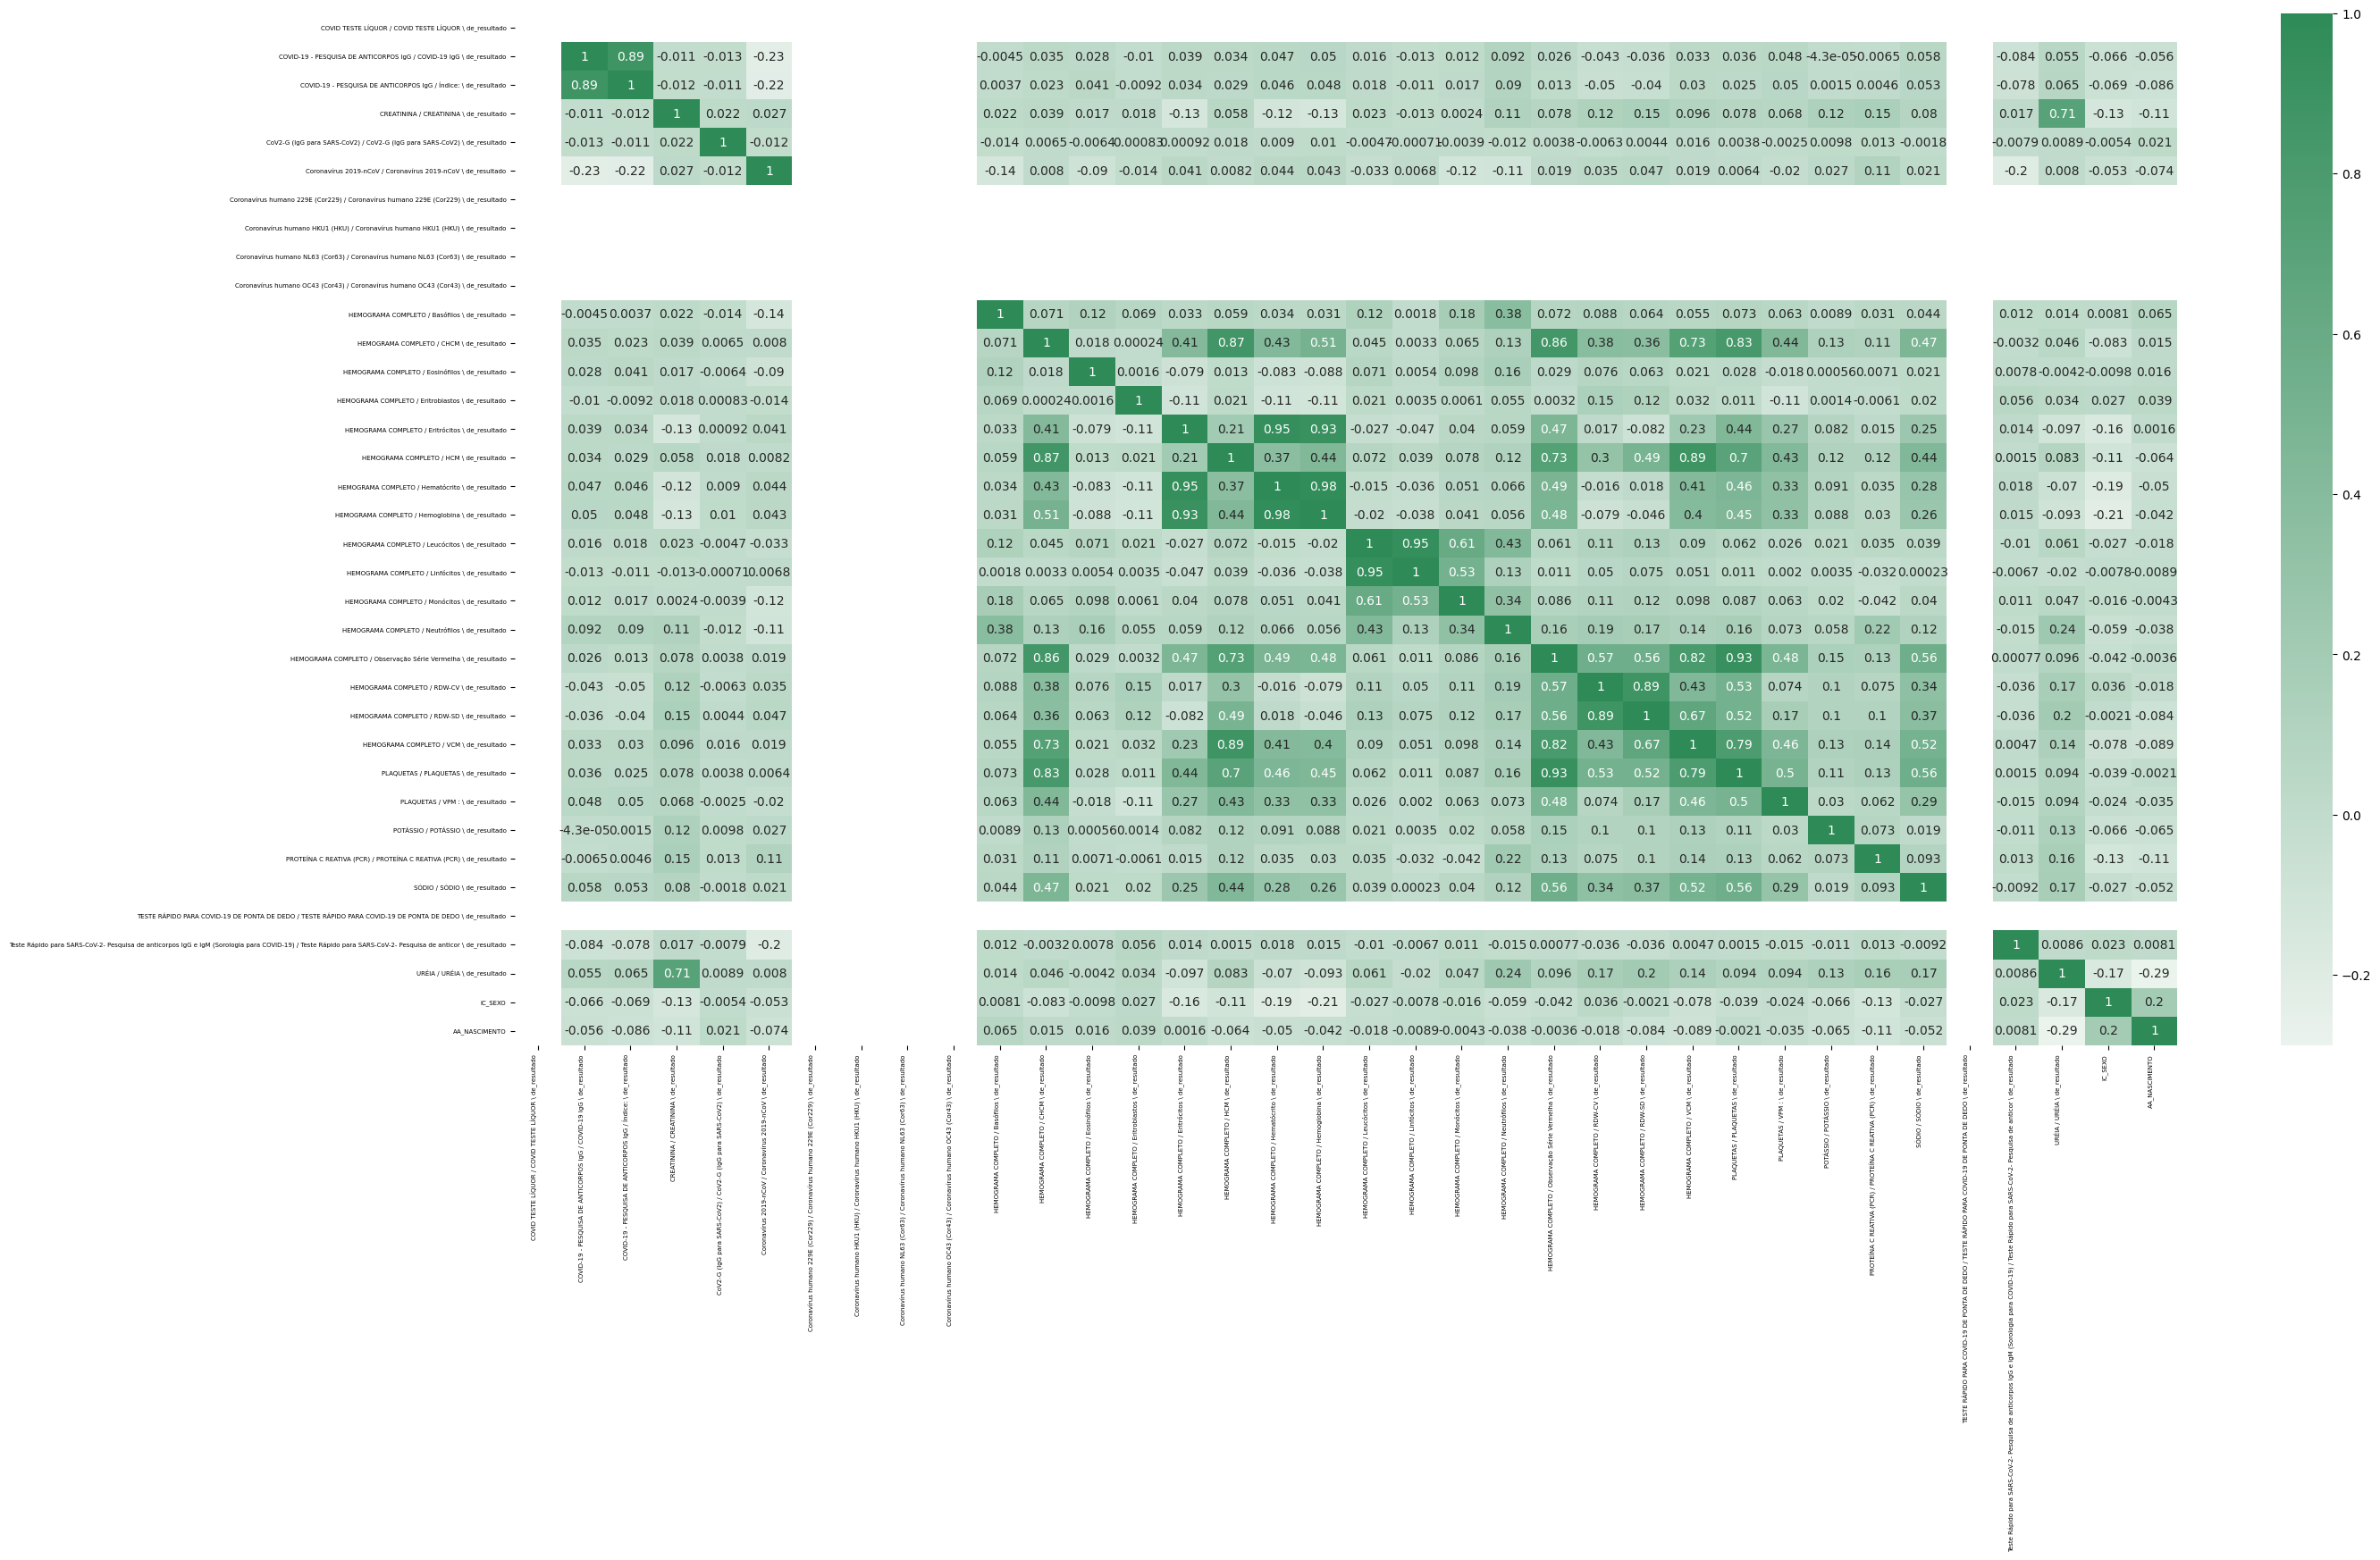

In [20]:
def verifica_correlacao(df):
  plt.figure(figsize=(30, 15))
  ax = sns.heatmap(
      df.corr(),
      annot=True,
      cmap=sns.light_palette("seagreen", as_cmap=True)
  )
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=5, rotation=90, ha='right')
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=5, rotation=0)
  plt.show()

verifica_correlacao(df_filtrado)

df_filtrado.to_csv("dados_filtrados.csv")

Numa análise rápida, os atributos não são correlacionados em sua maioria. O que significa que o uso deles vai trazer novas informações ao processamento na rede.